<a href="https://colab.research.google.com/github/WolfPitToad/GER-ENG-TransformerTranslation/blob/main/TransformersV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install --upgrade pip
!python -m pip install torchtext==0.6.0
!python -m pip install einops

In [ ]:
from einops import rearrange

In [ ]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List

In [ ]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io

In [ ]:
from torchtext.data import Field, BucketIterator

In [ ]:
#Previo al uso de datasets se rquiere instalar spicy para el facil manejo de los datos
import spacy
!python -m spacy download en
!python -m spacy download de


In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List
from spacy.lang.en.examples import sentences 

In [ ]:
SRC = Field(tokenize = "spacy",
            tokenizer_language="de_core_news_sm",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en_core_web_sm",
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)
#Obtenemos datos de ebtrenamiento, validación y prueba
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 478kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 175kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 167kB/s]


In [ ]:
#Generamos Vocabulario con palabras cuya aparicion minima sean 2 (requerido para que tenga al menos 2 referencias de uso)
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
#Necesario para realizar la traducción más adelante
# Obtenemos El token dada la posicion
print(TRG.vocab.itos) 
# Obtenemos el index del token dada una palabra
print(TRG.vocab.stoi)
# Obtenemos el index de una palabra dada una palabra
print(TRG.vocab.stoi['night'])

['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'woman', ',', 'two', 'are', 'to', 'people', 'at', 'an', 'wearing', 'shirt', 'young', 'white', 'black', 'his', 'while', 'blue', 'men', 'red', 'sitting', 'girl', 'boy', 'dog', 'standing', 'playing', 'group', 'street', 'down', 'walking', '-', 'front', 'her', 'holding', 'one', 'water', 'three', 'by', 'women', 'up', 'green', 'little', 'for', 'child', 'looking', 'outside', 'as', 'large', 'through', 'brown', 'yellow', 'children', 'person', 'from', 'their', 'hat', 'ball', 'into', 'small', 'next', 'other', 'dressed', 'some', 'out', 'over', 'building', 'riding', 'running', 'near', 'jacket', 'another', 'around', 'sidewalk', 'field', 'orange', 'crowd', 'beach', 'stands', 'pink', 'sits', 'jumping', 'behind', 'table', 'snow', 'grass', 'hair', 'background', 'bike', 'stand', 'city', "'s", 'air', 'girls', 'player', 'asian', 'looks', 'wall', 'top', 'four', 'off', 'dogs', 'several', 'that', 'older', 'camer

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
SOS_IDX = TRG.vocab.stoi['<sos>']
EOS_IDX = TRG.vocab.stoi['<eos>']
UNK_IDX = TRG.vocab.stoi['<unk>']
print('pad index:', PAD_IDX)
print('sos index:', SOS_IDX)
print('eos index:', EOS_IDX)
print('unk index:', UNK_IDX)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

pad index: 1
sos index: 2
eos index: 3
unk index: 0


In [ ]:
#Cargamos los modelos predefinidos del aleman e ingles para elaborar el tokenizer 
#nlp_de = spacy.load('de_core_news_sm')
#nlp_en = spacy.load('en_core_web_sm')
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'
en_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
de_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [ ]:
#Ejemplo del vocabulario en Ingles
doc = en_tokenizer("She ate the pizza")
#for token in doc:
print(doc)

['She', 'ate', 'the', 'pizza']


In [ ]:
#Ejemplo del vocabulario en Aleman
doc_de=de_tokenizer("Sie hat die Pizza gegessen")
print(doc_de)

['Sie', 'hat', 'die', 'Pizza', 'gegessen']


In [ ]:
print(TRG.vocab.__len__()) #Numero de palabras unicas del aleman

5893


In [ ]:
print(SRC.vocab.__len__()) #Numero de palabras unicas del aleman)

7853


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)
print(device)

cuda


In [ ]:
for _, batch in enumerate(train_iterator):
    src=batch.src
    tgt = batch.trg
print(src)
print(tgt)

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   5,    8,  948,  ...,    5,    8,    5],
        [1922,   36,  103,  ...,   26,  390,  114],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')
tensor([[  2,   2,   2,  ...,   2,   2,   2],
        [  4,   4, 209,  ...,   4,  21,   4],
        [166,  38,  70,  ...,  34, 145,  26],
        ...,
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1],
        [  1,   1,   1,  ...,   1,   1,   1]], device='cuda:0')


Estructura Básica de un transformer

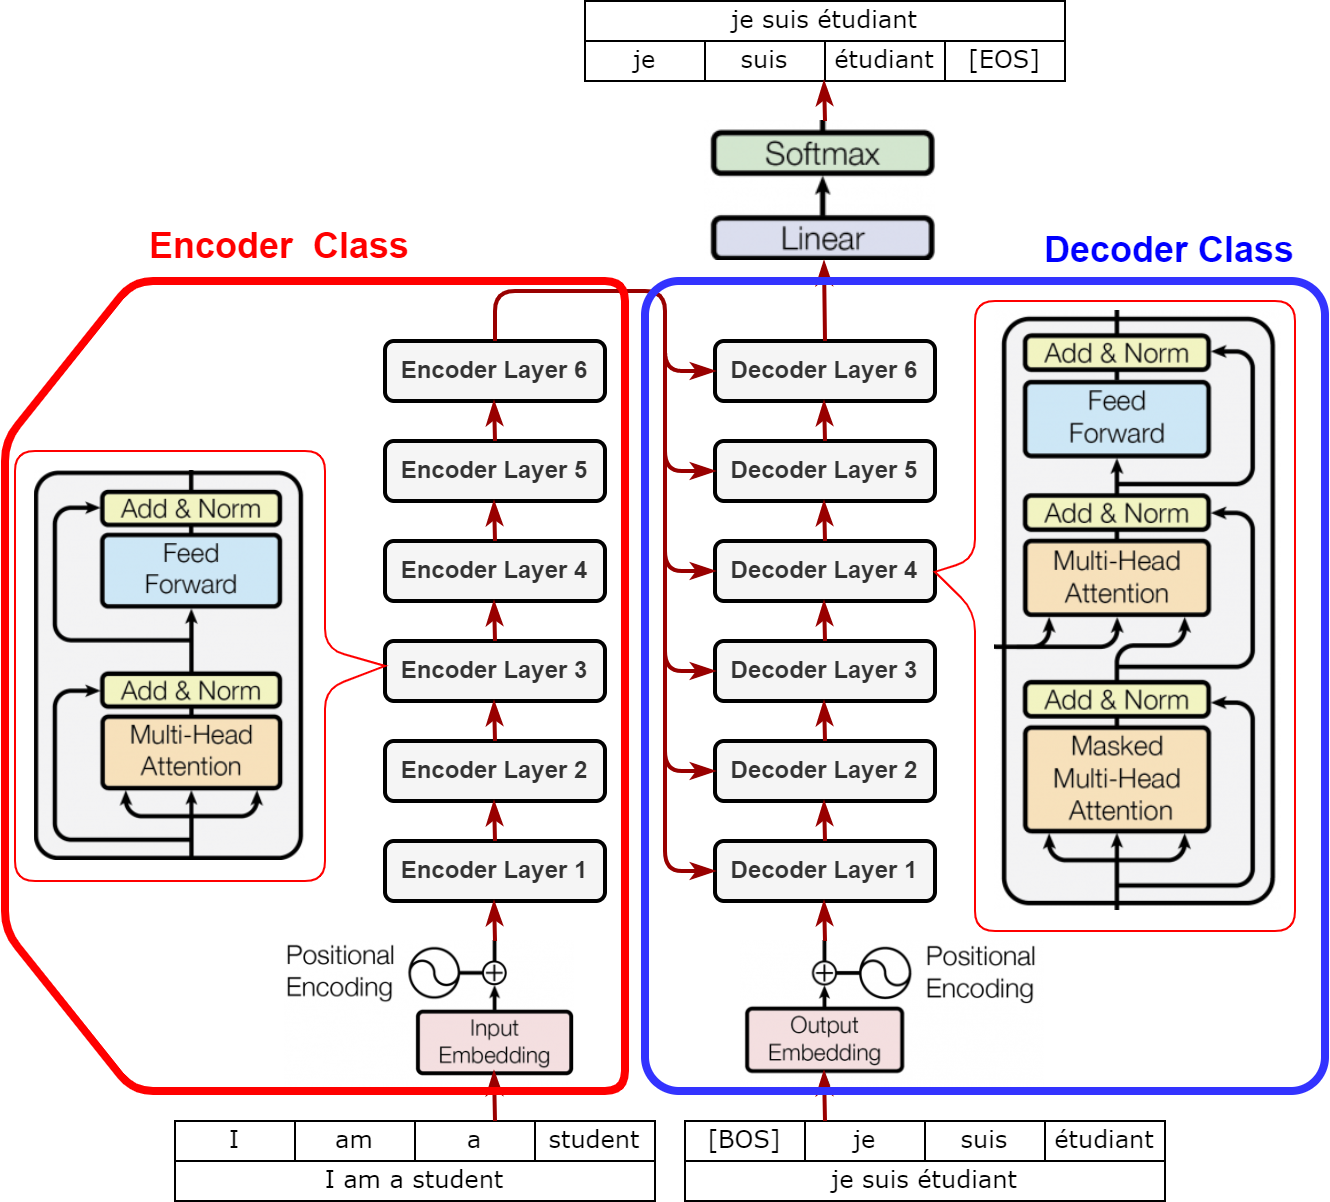

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

ENC_EMB_DIM = 32
DEC_EMB_DIM = 32
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ATTN_DIM = 8
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


In [ ]:
import random
from typing import Tuple

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor

import math

In [ ]:
class TransformerNetwork(nn.Module):
  def __init__(self):
    super(TransformerNetwork,self).__init__()
    pos_dropout = 0.1
    max_seq_length = 128
    self.pos_enc = PositionalEncoding(ENC_EMB_DIM, pos_dropout, max_seq_length) #Capa de positional encoding

    self.src_embedding= nn.Embedding(INPUT_DIM, ENC_EMB_DIM) #Capa de input encoding
    self.tgt_embedding= nn.Embedding(OUTPUT_DIM, ENC_EMB_DIM) #Capa de output encoding
    
    self.transformer= nn.Transformer(nhead=8, num_encoder_layers=2, d_model=ENC_EMB_DIM) #Capas de decoders/encoders
    self.linear = nn.Linear(ENC_EMB_DIM, OUTPUT_DIM) #Capa previa al final

  def forward(self, src, tgt, teacher_forcing_ratio=0.5, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None, tgt_mask=None):
        src_emb = self.pos_enc(self.src_embedding(src) * math.sqrt(ENC_EMB_DIM))
        tgt_emb = self.pos_enc(self.tgt_embedding(tgt) * math.sqrt(ENC_EMB_DIM))
        out = self.transformer(src_emb, tgt_emb, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        out = self.linear(out)
        return out    

Positional Encoding

#Se utiliza este metodo gracias a que... evita que la posición escale a numero grandes, normaliza la info de 0-1 El esquema posicional de los transformers funciona como una matriz donde cada fila de la matriz representa a un objeto sumado a su información posicional. Estas expresadas en la función seno/coseno se expresan como:

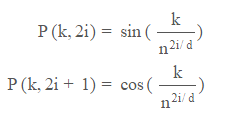

In [ ]:
emb_size=4
den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size) 
print(den)
maxlen=4
pos = torch.arange(0, maxlen).reshape(maxlen, 1)
print(pos)
pos_embedding = torch.zeros((maxlen, emb_size))
pos_embedding[:, 0::2] = torch.sin(pos * den) #ejemplo seno (0*1+) = 0 
pos_embedding[:, 1::2] = torch.cos(pos * den) #cos 0 =1
print(pos_embedding )

tensor([1.0000, 0.0100])
tensor([[0],
        [1],
        [2],
        [3]])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0100,  0.9999],
        [ 0.9093, -0.4161,  0.0200,  0.9998],
        [ 0.1411, -0.9900,  0.0300,  0.9996]])


Donde k es la posición de un objeto en L/2


d es la dimensión del embedding


n es el escalar definido por el usuario (10000)


i es el index


P(k,i) es la posición

In [ ]:
#Ejemplo de Position Encoding
import matplotlib.pyplot as plt
import numpy as np
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P
 
P = getPositionEncoding(seq_len=4, d=6, n=100)
print(P)

[[ 0.          1.          0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.21378067  0.97688169  0.04639922  0.99892298]
 [ 0.90929743 -0.41614684  0.41767683  0.90859565  0.0926985   0.99569422]
 [ 0.14112001 -0.9899925   0.60226103  0.79829922  0.1387981   0.9903207 ]]


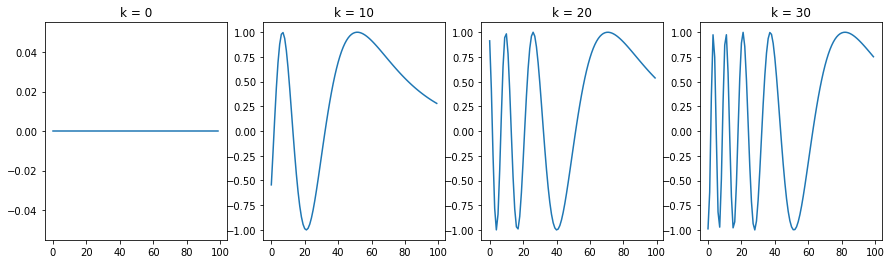

In [ ]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))
 
fig = plt.figure(figsize=(15, 4))    
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*10)

El positional encoding funciona similar a un reloj de x horas (dado a su movimiento circular, donde la manecilla pequeña se mueve a la par pero más lento que la grande de tal manera que no repite posiciones hasta que se defina la vuelta completa)

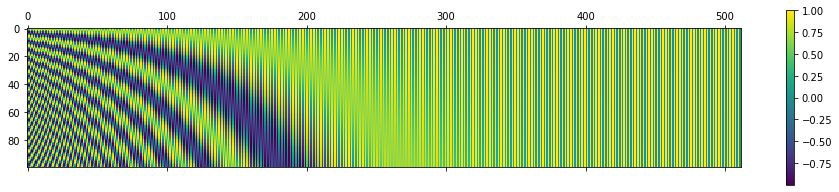

In [ ]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

Colocando de nuevo el ejemplo del reloj, para evirtar que cada "12 horas" repita posicioneses importante que el emb_size sea < a la max_len

In [ ]:
emb_size=6
den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size) #Nuestra constante que define la longuitud de onda
print(den)
maxlen=4
pos = torch.arange(0, maxlen).reshape(maxlen, 1)
print(pos)
pos_embedding = torch.zeros((maxlen, emb_size))
pos_embedding[:, 0::2] = torch.sin(pos * den) #ejemplo seno (0*1+) = 0 
pos_embedding[:, 1::2] = torch.cos(pos * den) #cos 0 =1
print(pos_embedding ) #Observamos como al sobre pasar la max len la matriz vuelve a repetir valores, una vez establecidas las bases

tensor([1.0000, 0.0464, 0.0022])
tensor([[0],
        [1],
        [2],
        [3]])
tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0464,  0.9989,  0.0022,  1.0000],
        [ 0.9093, -0.4161,  0.0927,  0.9957,  0.0043,  1.0000],
        [ 0.1411, -0.9900,  0.1388,  0.9903,  0.0065,  1.0000]])


In [ ]:
#El esquema posicional de los transformers funciona como una matriz donde cada fila de la matriz representa a un "objeto sumado" a su información posicional.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout) #Colocamos una capa de drop out para que no "memorice"
        pe = torch.zeros(max_len, d_model) #Inicializamos matriz en ceros 
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #Posición de un objeto (coordenadas) 0 a max leng En forma de vector
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) #math.log(10000) = Obtenido del paper Attention is all you need = 5000*2 esta variable modula la longitud de onda (2*i/c)
        pe[:, 0::2] = torch.sin(position * div_term) #Rellenamos columnas de posición numeros pares seno
        pe[:, 1::2] = torch.cos(position * div_term)  #Rellenamos columnas de posición numeros impares coseno
        pe = pe.unsqueeze(0).transpose(0, 1) #
        self.register_buffer('pe', pe) #Agregamos un registro (BUFFER)

    def forward(self, x): #Definimos función para "continuar el entrenamiento"
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
transformer=TransformerNetwork()

In [ ]:
for p in transformer.parameters(): #Inicialización previa
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

#Optimizador
optimizer = optim.Adam(transformer.parameters(), betas=(0.9, 0.98))

#Imprimimos numeros de parametros
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in transformer.parameters() if p.requires_grad)


print(f'El modelo tiene {count_parameters(transformer):,} parametros entrenables')

El modelo tiene 1,760,229 parametros entrenables


In [ ]:
#Observamos arquitectura
print(transformer.children)

<bound method Module.children of TransformerNetwork(
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (src_embedding): Embedding(7853, 32)
  (tgt_embedding): Embedding(5893, 32)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
          )
          (linear1): Linear(in_features=32, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=32, bias=True)
          (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
      

In [ ]:
##!pip install git+https://github.com/szagoruyko/pytorchviz.git@master
##from torchviz import make_dot, make_dot_from_trace

#Generamos mascara (requerida para unir decoder y encoder) y con la finalidad de ocultarle información al transformer
https://machinelearningmastery.com/joining-the-transformer-encoder-and-decoder-and-masking/

In [ ]:
 mask = (torch.triu(torch.ones((5, 5), device=device)) == 1).transpose(0, 1)
 print(mask)

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True]], device='cuda:0')


In [ ]:
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
print(mask)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]], device='cuda:0')


In [ ]:
def generate_square_subsequent_mask(length):
    mask = rearrange(torch.triu(torch.ones((length, length)) == 1),'h w -> w h') #triu genera una matriz triangular con ciertos y falsos
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)) #Gracias a la función mask_fill se genera automaticamente una máscara
    #para los objetos generados como True o 1, llenamos con 0 para los elementos Falsos llenamos con -inf
    return mask

In [ ]:
from torch.nn import (TransformerEncoder, TransformerDecoder,TransformerEncoderLayer, TransformerDecoderLayer)

In [ ]:
from numpy.core.fromnumeric import clip
def trainTransformer(model:nn.Module, iterator:BucketIterator, optimizer:optim.Optimizer,criterion:nn.Module, clip:float):
  model.train()
  epoch_loss = 0
  for _, batch in enumerate(train_iterator):
        src=batch.src #La secuencia para el encoder
        tgt = batch.trg #La secuencia para el decoder
        optimizer.zero_grad() 

        src_key_padding_mask = src == PAD_IDX #Diferenciamos datos de Source y Target mediante el <pad>
        tgt_key_padding_mask = tgt == PAD_IDX
        memory_key_padding_mask = src_key_padding_mask.clone() #Mascara de los caracteres del objetivo
        src_key_padding_mask = rearrange(src_key_padding_mask, 'n s -> s n') #La mascara para el encoder (por batch)
        tgt_key_padding_mask = rearrange(tgt_key_padding_mask, 'n s -> s n') #La mascara del decoder (por batch)
        memory_key_padding_mask = rearrange(memory_key_padding_mask, 'n s -> s n') #Mascara de los caracteres del objetivo"
        tgt_sentence_len = tgt.shape[0] - torch.sum(tgt_key_padding_mask, axis=1)
        tgt_inp, tgt_out = tgt[:-1, :], tgt[1:, :] #Similar a l a practica del RNN, generamos pares de secuencias objetivo y actual
        tgt_key_padding_mask = tgt_key_padding_mask[:, :-1]
        tgt_mask = generate_square_subsequent_mask(tgt_inp.shape[0]).to(device) #Generamos mascara triangular
        output = model(src, tgt_inp, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask)
        from_one_hot = torch.argmax(output, dim=2) #Reacomodamos por mayor probabilidad
        output = output.view(-1, output.shape[-1]) #Se requiere para evaluar la red
        tgt_out = tgt_out.view(-1) #Se requiere para evaluar la red
        loss = criterion(output, tgt_out) #Observamos el desempeño de la red
        loss.backward() #Se calculan los gradientes de cada parametro
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) #Se concatenan las mascaras de atención
        optimizer.step() #Actualizamos el modelo
        epoch_loss += loss.item() #Obtenemos el valor de la perdida
  return epoch_loss / len(iterator)

def evaluateTransformer(model:nn.Module,iterator:BucketIterator,criterion:nn.Module):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
        for _, batch in enumerate(iterator):

            src = batch.src #La secuencia para el encoder 
            tgt = batch.trg  #La secuencia para el decoder
            src_key_padding_mask = src == PAD_IDX #Diferenciamos datos de Source y Target mediante el <pad>
            tgt_key_padding_mask = tgt == PAD_IDX
            memory_key_padding_mask = src_key_padding_mask.clone() #Mascara de los caracteres del objetivo
            src_key_padding_mask = rearrange(src_key_padding_mask, 'n s -> s n') #La mascara para el encoder (por batch)
            tgt_key_padding_mask = rearrange(tgt_key_padding_mask, 'n s -> s n') #La mascara del decoder (por batch)
            memory_key_padding_mask = rearrange(memory_key_padding_mask, 'n s -> s n') #Mascara de los caracteres del objetivo"
            tgt_mask = generate_square_subsequent_mask(tgt.shape[0]).to(device) #Generamos mascara triangular
            output = model(src, tgt, 0, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask) #turn off teacher forcing
            from_one_hot = torch.argmax(output, dim=2)  #Reacomodamos por mayor probabilidad

            output = output[1:].view(-1, output.shape[-1])
            src_words = indices_to_string(SRC, src) #Enviamos a transformar los indices a str
            predicted_words = indices_to_string(TRG, from_one_hot) #Observamos las predicciones
            tgt_words = indices_to_string(TRG, tgt) #Convertimos las palabras objetivo de indices a str
            tgt = tgt[1:].view(-1)
            loss = criterion(output, tgt) #Calculamos perdida
            epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [ ]:
def indices_to_string(LANGUAGE, batch):
    words_list = [] #Conteo de oraciones
    for sentence in batch.transpose(1, 0): #Por cada oración dentro del batch
        sentence_list = sentence.tolist() #Se mandara la oración a una lista
        words = [] #Conteo de palabras
        for index in sentence_list: #Por cada index
            word = LANGUAGE.vocab.itos[index] #Se recupera la palabra
            words.append(word) #Se añaden las palabras en la lista de palabras
        words_list.append(words) #Se añaden las oraciones en la lista de oraciones
    return words_list

def string_to_indices(LANGUAGE, sentence):
    words = sentence.split() #La oración se divide en sus palabras
    indices = [] #Conteo de indices
    for word in words: #Por cada palabra en cada oración
        if word in LANGUAGE.vocab.stoi: #Si la palabra se encuentra dentro del vocabulario
            index = LANGUAGE.vocab.stoi[word] #Buscamos el indice de esa palabra
            indices.append(index) #Se añaden los indices a la lista
        else:
            index = LANGUAGE.vocab.stoi['<unk>'] #En caso contrario se añade el <unk>
            indices.append(index) #a la lista de indices
    result = torch.tensor(indices) #Regresamos los indices
    return result

In [ ]:
from inspect import trace
tran=TransformerNetwork().to(device)

In [ ]:
for p in tran.parameters(): #Inicialización previa
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

#Optimizador
optimizer = optim.Adam(tran.parameters(), betas=(0.9, 0.98))

#Imprimimos numeros de parametros
def count_parameters(model: nn.Module):
    return sum(p.numel() for p in tran.parameters() if p.requires_grad)


print(f'El modelo tiene {count_parameters(tran):,} parametros entrenables')

El modelo tiene 1,760,229 parametros entrenables


In [ ]:
import time

In [ ]:
N_EPOCHS = 5
CLIP = 1
for epoch in range(N_EPOCHS):
    train_loss = trainTransformer(tran, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluateTransformer(tran, valid_iterator, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
test_loss = evaluateTransformer(tran, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

Epoch: 01
	Train Loss: 2.855 | Train PPL:  17.366
	 Val. Loss: 8.043 |  Val. PPL: 3112.131
Epoch: 02
	Train Loss: 2.668 | Train PPL:  14.417
	 Val. Loss: 8.185 |  Val. PPL: 3586.435
Epoch: 03
	Train Loss: 2.514 | Train PPL:  12.356
	 Val. Loss: 8.458 |  Val. PPL: 4712.331
Epoch: 04
	Train Loss: 2.384 | Train PPL:  10.844
	 Val. Loss: 8.887 |  Val. PPL: 7236.433
Epoch: 05
	Train Loss: 2.272 | Train PPL:   9.702
	 Val. Loss: 8.885 |  Val. PPL: 7222.320
| Test Loss: 8.851 | Test PPL: 6983.621 |


In [ ]:
def example_translate(model, example_sentence_src):
    # Traduccir ejemplo
    example_tensor_src = string_to_indices(SRC, example_sentence_src).view(-1, 1)
    example_sentence_tgt = '<sos>'
    example_tensor_tgt = string_to_indices(TRG, example_sentence_tgt).view(-1, 1)
    src = example_tensor_src.to(device)
    tgt = example_tensor_tgt.to(device)

    print('----------Traduciendo--------------')
    for i in range(128):
        src_key_padding_mask = src == PAD_IDX
        tgt_key_padding_mask = tgt == PAD_IDX
        memory_key_padding_mask = src_key_padding_mask.clone()
        src_key_padding_mask = rearrange(src_key_padding_mask, 'n s -> s n')
        tgt_key_padding_mask = rearrange(tgt_key_padding_mask, 'n s -> s n')
        memory_key_padding_mask = rearrange(memory_key_padding_mask, 'n s -> s n')
        tgt_mask = generate_square_subsequent_mask(tgt.shape[0]).to('cuda')

        output = model(src, tgt, 0, src_key_padding_mask=src_key_padding_mask, tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask, tgt_mask=tgt_mask) #turn off teacher forcing

        output_index = torch.argmax(output, dim=2)[-1].item()
        output_word = TRG.vocab.itos[output_index]
        example_sentence_tgt = example_sentence_tgt + ' ' + output_word
        print('Oración:', example_sentence_tgt)
        example_tensor_tgt = string_to_indices(TRG, example_sentence_tgt).view(-1, 1)
        tgt = example_tensor_tgt.to(device)
        if output_word == '<eos>':
            break
    print('-----------Fin--------------')

In [ ]:
example_sentence_src = '<sos>  die in der dunklen straße spazieren gehen, während ein auto wegfährt'
example_translate(tran, example_sentence_src)

----------Translating--------------
Translated sentence so far: <sos> two
Translated sentence so far: <sos> two <unk>
Translated sentence so far: <sos> two <unk> in
Translated sentence so far: <sos> two <unk> in red
Translated sentence so far: <sos> two <unk> in red are
Translated sentence so far: <sos> two <unk> in red are walking
Translated sentence so far: <sos> two <unk> in red are walking down
Translated sentence so far: <sos> two <unk> in red are walking down the
Translated sentence so far: <sos> two <unk> in red are walking down the street
Translated sentence so far: <sos> two <unk> in red are walking down the street while
Translated sentence so far: <sos> two <unk> in red are walking down the street while a
Translated sentence so far: <sos> two <unk> in red are walking down the street while a blue
Translated sentence so far: <sos> two <unk> in red are walking down the street while a blue car
Translated sentence so far: <sos> two <unk> in red are walking down the street while a 

https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html

https://www.analyticsvidhya.com/blog/2021/06/language-translation-with-transformer-in-python/

https://arusl.medium.com/japanese-english-language-translation-with-transformer-using-pytorch-243738146806

https://youtu.be/U0s0f995w14

https://blog.floydhub.com/the-transformer-in-pytorch/

https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

https://machinelearningmastery.com/the-transformer-model/

https://paperswithcode.com/paper/attention-is-all-you-need

https://github.com/pytorch/tutorials/blob/master/beginner_source/translation_transformer.py

https://stackoverflow.com/questions/62170439/difference-between-src-mask-and-src-key-padding-mask

https://anthonydave.top/Deep%20Learning/My-journey-to-transformer/

https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html